In [1]:
# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import datetime

# fix the seed for consistent interpretation of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.4.1


In [2]:
from tqdm.notebook import tqdm

In [3]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS 

In [5]:
import phenom

# rational layer

In [7]:
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers, regularizers, constraints

In [8]:
class RationalLayer(Layer):
    """Rational Activation function.
    It follows:
    `f(x) = P(x) / Q(x),
    where the coefficients of P and Q are learned array with the same shape as x.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        alpha_initializer: initializer function for the weights of the numerator P.
        beta_initializer: initializer function for the weights of the denominator Q.
        alpha_regularizer: regularizer for the weights of the numerator P.
        beta_regularizer: regularizer for the weights of the denominator Q.
        alpha_constraint: constraint for the weights of the numerator P.
        beta_constraint: constraint for the weights of the denominator Q.
        shared_axes: the axes along which to share learnable
            parameters for the activation function.
            For example, if the incoming feature maps
            are from a 2D convolution
            with output shape `(batch, height, width, channels)`,
            and you wish to share parameters across space
            so that each filter only has one set of parameters,
            set `shared_axes=[1, 2]`.
    # Reference
        - [Rational neural networks](https://arxiv.org/abs/2004.01902)
    """

    def __init__(self, alpha_initializer=[1.1915, 1.5957, 0.5, 0.0218], beta_initializer=[2.383, 0.0, 1.0], 
                 alpha_regularizer=None, beta_regularizer=None, alpha_constraint=None, beta_constraint=None,
                 shared_axes=None, **kwargs):
        super(RationalLayer, self).__init__(**kwargs)
        self.supports_masking = True

        # Degree of rationals
        self.degreeP = len(alpha_initializer) - 1
        self.degreeQ = len(beta_initializer) - 1
        
        # Initializers for P
        self.alpha_initializer = [initializers.Constant(value=alpha_initializer[i]) for i in range(len(alpha_initializer))]
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        
        # Initializers for Q
        self.beta_initializer = [initializers.Constant(value=beta_initializer[i]) for i in range(len(beta_initializer))]
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        
        if shared_axes is None:
            self.shared_axes = None
        elif not isinstance(shared_axes, (list, tuple)):
            self.shared_axes = [shared_axes]
        else:
            self.shared_axes = list(shared_axes)

    def build(self, input_shape):
        param_shape = list(input_shape[1:])
        if self.shared_axes is not None:
            for i in self.shared_axes:
                param_shape[i - 1] = 1
        
        self.coeffsP = []
        for i in range(self.degreeP+1):
            # Add weight
            alpha_i = self.add_weight(shape=param_shape,
                                     name='alpha_%s'%i,
                                     initializer=self.alpha_initializer[i],
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
            self.coeffsP.append(alpha_i)
            
        # Create coefficients of Q
        self.coeffsQ = []
        for i in range(self.degreeQ+1):
            # Add weight
            beta_i = self.add_weight(shape=param_shape,
                                     name='beta_%s'%i,
                                     initializer=self.beta_initializer[i],
                                     regularizer=self.beta_regularizer,
                                     constraint=self.beta_constraint)
            self.coeffsQ.append(beta_i)
        
        # Set input spec
        axes = {}
        if self.shared_axes:
            for i in range(1, len(input_shape)):
                if i not in self.shared_axes:
                    axes[i] = input_shape[i]
                    self.input_spec = InputSpec(ndim=len(input_shape), axes=axes)
                    self.built = True

    def call(self, inputs, mask=None):
        # Evaluation of P
        outP = tf.math.polyval(self.coeffsP, inputs)
        # Evaluation of Q
        outQ = tf.math.polyval(self.coeffsQ, inputs)
        # Compute P/Q
        out = tf.math.divide(outP, outQ)
        return out

    def get_config(self):
        config = {
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RationalLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

# main

In [9]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, val):
        super(ThresholdCallback, self).__init__()
        self.val = val
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= self.val:
            self.model.stop_training = True

In [10]:
def gen_model_waveforms(approx, qlist, npts, t_min, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_min=t_min, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_min=t_min, t_max=t_max) for q in qlist]

In [11]:
def make_training_set(wfs, attr, scale_by_eta=False):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    
    if scale_by_eta:
        eta = phenom.eta_from_q(x)[:, np.newaxis]
        return {'x':x, 'y':y/eta}
    else:
        return {'x':x, 'y':y}

In [12]:
def generate_case(q, approx="SEOBNRv4_opt", npts=1000, t_min=-2000, t_max=75, data_to_model='phase', scale_by_eta=False):
    model_wf = gen_model_waveforms(approx, np.atleast_1d(q), npts, t_min=t_min, t_max=t_max)
    return make_training_set(model_wf, data_to_model, scale_by_eta=scale_by_eta)

In [15]:
def build_encoder(input_shape, latent_dim, act="rational"):
    # build the encoder    
    timeseries_input = keras.Input(shape=(input_shape, ))
    
    if act=="rational":
        x = layers.Dense(128)(timeseries_input)
        x = RationalLayer()(x)
        x = layers.Dense(16)(x)
        x = RationalLayer()(x)
    else:
        x = layers.Dense(128, activation=act)(timeseries_input)
        x = layers.Dense(16, activation=act)(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_AE = keras.Model(timeseries_input, latent_output)
#     encoder_AE.summary()
    
    return encoder_AE

In [16]:
def build_decoder(input_shape, latent_dim, act="rational"):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    if act=="rational":
        x = layers.Dense(16)(latent_input)
        x = RationalLayer()(x)
        x = layers.Dense(128)(x)
        x = RationalLayer()(x)
    else:
        x = layers.Dense(16, activation=act)(latent_input)
        x = layers.Dense(128, activation=act)(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_AE = keras.Model(latent_input, timeseries_output)
#     decoder_AE.summary()
    
    return decoder_AE

In [17]:
def build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape, ))
    latent = encoder_AE(timeseries_input)
    timeseries_output = decoder_AE(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss='mse')
    
    return ae_model

In [18]:
def plot_latent_space_1d_for_each_model(model_ts, encoder_AE, figsize=None):
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])
    
    print(xs.shape)
    print(ys.shape)
    print(latent_space.shape)
    
    for i in range(latent_space.shape[2]):
        plt.figure(figsize=figsize)
        for n,k in enumerate(model_ts.keys()):
            plt.plot(xs[n], latent_space[n,:,i], '-', label=f'{k}')
        plt.legend()
        plt.title(f'latent space: {i}')
        plt.show()
        plt.close()

In [19]:
def interpolate_latent_space_min_max(model_ts, encoder_AE):
    """
    assumes that xs array are the same. would have to resample all to same grid in the future
    """
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])
    
    y_mins = np.min(latent_space, axis=0)
    y_maxs = np.max(latent_space, axis=0)
    
    results = {}
    labels = ['min', 'max']
    for k in labels:
        interpolations = []
        if k == 'min':
            y = y_mins
        elif k == 'max':
            y = y_maxs
        for i in range(latent_space.shape[2]):
            interpolations.append(IUS(xs[0], y[:,i]))
        results.update({k:interpolations})
    
    return results

In [20]:
def interpolate_latent_space(model_ts, encoder_AE):
    xs = np.asarray([model_ts[k]['x'] for k in model_ts.keys()])
    ys = np.asarray([model_ts[k]['y'] for k in model_ts.keys()])
    
    latent_space = np.asarray([encoder_AE.predict(y) for y in ys])

    results = {}
    
    for n, k in enumerate(model_ts.keys()):
        interpolations = []
        for i in range(latent_space.shape[2]):
            interpolations.append(IUS(xs[n], latent_space[n,:,i]))
        results.update({k:interpolations})
    
    return results

In [21]:
def plot_prediction(index, n_samples=0):
    
    latent_true = train_encodings_AE[index][np.newaxis,:]
    
    if n_samples:
        rvs = np.random.uniform(latent_true-0.1, latent_true+0.1, size=(n_samples, latent_dim))
        yhats = decoder_AE.predict(rvs)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(common_times, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(common_times, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(common_times, train_y[index], lw=2)
    plt.plot(common_times, decoder_AE.predict(latent_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_x[index]}')
    
#     plt.xlim(-100, 100)
#     plt.yscale('log')
    plt.show()
    plt.close()

In [22]:
def predict(q, decoder_AE, latent_space_interpolations):
    latent_space = np.asarray([f(q) for f in latent_space_interpolations])
    latent_space = latent_space[np.newaxis, :]

    return decoder_AE.predict(latent_space)

In [23]:
def match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)


    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    res = ifft / h1h1 / h2h2 * 4 * dt

    return np.max(np.abs(res))


# main

In [146]:
def run_ae_fit(train_y, epochs, batch_size, stop_threshold, latent_dim=2):
    act = "rational"
    #     act = "relu"
    # act = "tanh"
    input_shape = train_y.shape[1] # number of time points
    learning_rate=1e-4
    amsgrad=False
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=amsgrad)
    # opt = tfa.optimizers.NovoGrad(learning_rate=learning_rate, amsgrad=amsgrad)
#     opt = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
    # opt = tfa.optimizers.LAMB(learning_rate=learning_rate)
    # opt = tfa.optimizers.Yogi(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    # opt = tfa.optimizers.Lookahead(opt)

    encoder_AE = build_encoder(input_shape, latent_dim, act)
    decoder_AE = build_decoder(input_shape, latent_dim, act)
    ae_model = build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt)
    # encoder_AE.summary()
    # decoder_AE.summary()
    # ae_model.summary()


    callbacks = []

    # first_decay_steps = 20
    # first_decay_steps = 400
    # first_decay_steps = 1200*4
    # learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)

    # learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(learning_rate, 1e-8, first_decay_steps)
    # learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(1e-8, learning_rate, first_decay_steps, gamma=0.999)

    initial_learning_rate=1e-6
    maximal_learning_rate=1e-3
    step_size=200
    gamma=0.9
    # initial_learning_rate=1e-3
    # maximal_learning_rate=1e-2
    # step_size=1000
    # gamma=1

    learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(
                initial_learning_rate=initial_learning_rate,
                maximal_learning_rate=maximal_learning_rate,
                step_size=step_size,
                scale_mode="cycle",
                gamma=gamma)


    callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    callbacks.append(ThresholdCallback(stop_threshold))
    
#     callbacks.append(ThresholdCallback(1e-4)) # for the phase if it hasn't been normalised
    # callbacks.append(ThresholdCallback(1e-7))
    
    start_time = datetime.datetime.now()
    ae_history = ae_model.fit(train_y, train_y, epochs=epochs, callbacks=callbacks, batch_size=batch_size, verbose=0)
    end_time = datetime.datetime.now()
    
    duration = end_time - start_time
    print("fit complete")
    print(f"duration: {duration}")
    
    plt.figure()
    plt.plot(ae_history.history['loss'])
    # plt.plot(ae_history.history['val_loss'])
    plt.yscale('log')
    plt.xscale('log')
    
    return ae_model, ae_history, encoder_AE, decoder_AE

# common hyper parameters

In [25]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomC"]
approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
# q_max = 2
q_max = 19
# q_min = 19
# q_max = 30
dq = 0.1

q_arr = np.arange(q_min, q_max, dq)

# time points
# npts=1000
npts=5000
# t_min=-500
t_min=-2000
t_max=75

In [26]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

In [27]:
common_times = model_wfs[start_approx][0].times

In [28]:
model_ts = {}

In [29]:
train_x = {}
train_y = {}

In [30]:
scale_param = {}

In [31]:
ae_model = {}
ae_history = {}
encoder = {}
decoder = {}

In [32]:
train_encodings_AE = {}

In [33]:
interpolations = {}

In [34]:
interpolations_min_max = {}

# amp data

In [35]:
# data_to_model = 'Reh22'
data_to_model = 'amp'
# data_to_model = 'phase'
# data_to_model = 'freq'

scale_by_eta=True
# scale_by_eta=False

In [36]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts[data_to_model] = {}
for approx in approxs:
    model_ts[data_to_model].update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=scale_by_eta)})

In [37]:
# the training set will just be the concatonated list of all waveforms
# from each model
train_x[data_to_model] = np.concatenate([model_ts[data_to_model][k]['x'] for k in model_ts[data_to_model].keys()])
train_y[data_to_model] = np.concatenate([model_ts[data_to_model][k]['y'] for k in model_ts[data_to_model].keys()])

In [38]:
train_y[data_to_model].shape

(180, 5000)

In [39]:
train_x[data_to_model].shape

(180,)

In [40]:
scale_param[data_to_model] = np.max(train_y[data_to_model])
train_y[data_to_model] = train_y[data_to_model]/scale_param[data_to_model]
for approx in approxs:
    model_ts[data_to_model][approx]['y'] = model_ts[data_to_model][approx]['y']/scale_param[data_to_model]

## fits


fit complete
duration: 0:28:08.296542


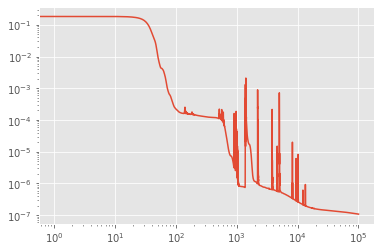

In [147]:
data_to_model = 'amp'
# stop_threshold=5e-5
stop_threshold=1e-7
epochs=100000
# epochs=10000
# epochs=2000
# epochs=4000
# epochs=500
ae_model[data_to_model], ae_history[data_to_model], encoder[data_to_model], decoder[data_to_model] = run_ae_fit(train_y=train_y[data_to_model], epochs=epochs, batch_size=32*8, stop_threshold=stop_threshold, latent_dim=2)

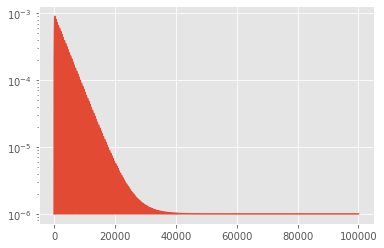

In [148]:
plt.figure()
plt.plot(ae_history[data_to_model].history['lr'])
plt.yscale('log')
# plt.xscale('log')

In [149]:
train_encodings_AE[data_to_model] = encoder[data_to_model].predict(train_y[data_to_model])

In [150]:
train_encodings_AE[data_to_model].shape

(180, 2)

(1, 180)
(1, 180, 5000)
(1, 180, 2)


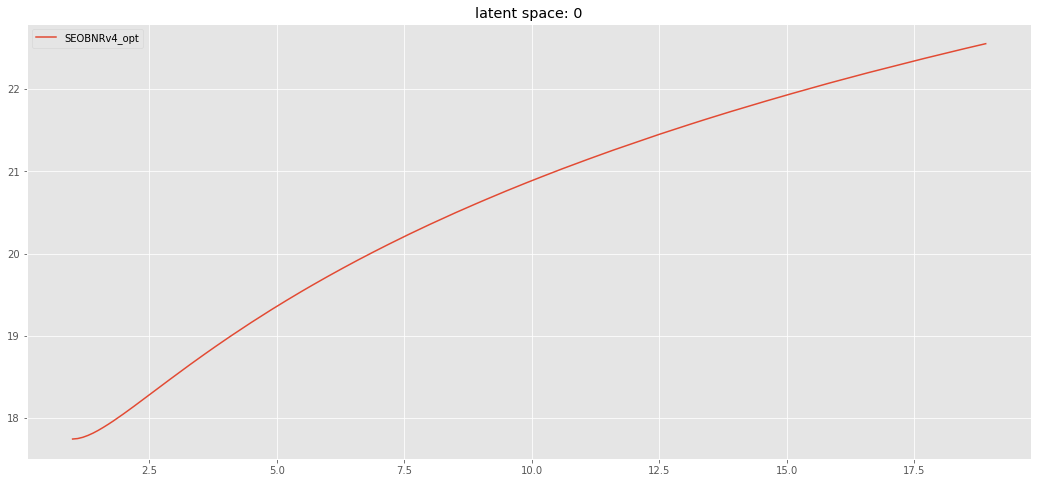

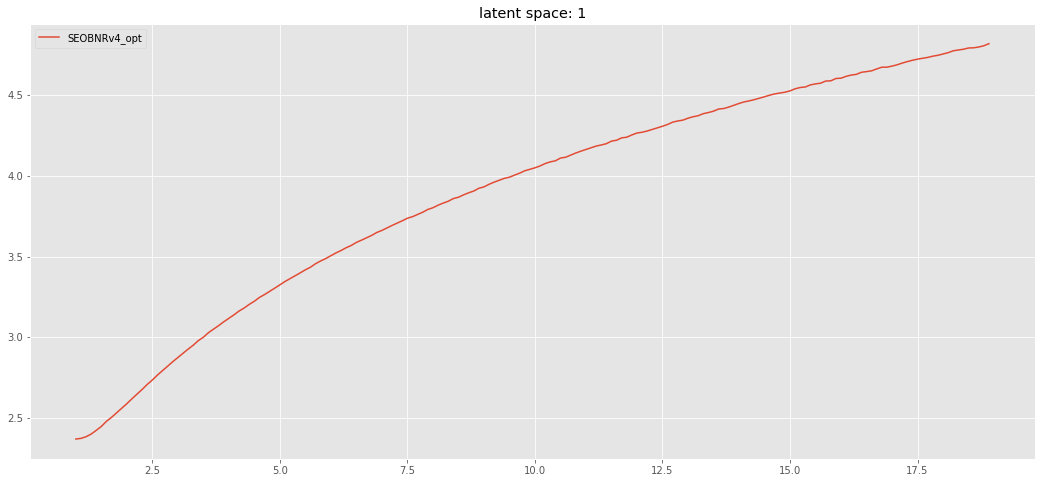

In [151]:
plot_latent_space_1d_for_each_model(model_ts[data_to_model], encoder[data_to_model], figsize=(18, 8))

In [152]:
interpolations_min_max[data_to_model] = interpolate_latent_space_min_max(model_ts[data_to_model], encoder[data_to_model])

In [153]:
interpolations[data_to_model] = interpolate_latent_space(model_ts[data_to_model], encoder[data_to_model])

In [154]:
# plt.figure()
# plt.plot(model_ts[data_to_model]['IMRPhenomD']['x'], interpolations[data_to_model]['IMRPhenomD'][0](model_ts[data_to_model]['IMRPhenomD']['x']))

In [155]:
# predict(1, decoder[data_to_model], interpolations[data_to_model]['IMRPhenomD'])

# phase data

In [55]:
# data_to_model = 'Reh22'
# data_to_model = 'amp'
data_to_model = 'phase'
# data_to_model = 'freq'

# scale_by_eta=True
scale_by_eta=False

In [56]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts[data_to_model] = {}
for approx in approxs:
    model_ts[data_to_model].update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=scale_by_eta)})

In [57]:
# the training set will just be the concatonated list of all waveforms
# from each model
train_x[data_to_model] = np.concatenate([model_ts[data_to_model][k]['x'] for k in model_ts[data_to_model].keys()])
train_y[data_to_model] = np.concatenate([model_ts[data_to_model][k]['y'] for k in model_ts[data_to_model].keys()])

In [58]:
train_y[data_to_model].shape

(180, 5000)

In [59]:
train_x[data_to_model].shape

(180,)

In [60]:
scale_param[data_to_model] = np.min(train_y[data_to_model])
train_y[data_to_model] = train_y[data_to_model]/scale_param[data_to_model]
for approx in approxs:
    model_ts[data_to_model][approx]['y'] = model_ts[data_to_model][approx]['y']/scale_param[data_to_model]

## fits


fit complete
duration: 0:03:35.147627


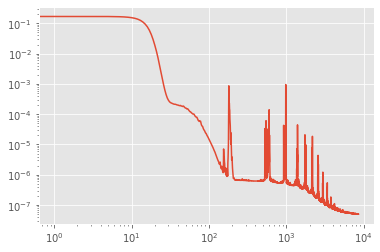

In [125]:
data_to_model = 'phase'
stop_threshold=5e-8
epochs=10000
# epochs=1000
# epochs=500
ae_model[data_to_model], ae_history[data_to_model], encoder[data_to_model], decoder[data_to_model] = run_ae_fit(train_y=train_y[data_to_model], epochs=epochs, batch_size=32, stop_threshold=stop_threshold, latent_dim=2)

In [126]:
train_encodings_AE[data_to_model] = encoder[data_to_model].predict(train_y[data_to_model])

In [127]:
train_encodings_AE[data_to_model].shape

(180, 2)

(1, 180)
(1, 180, 5000)
(1, 180, 2)


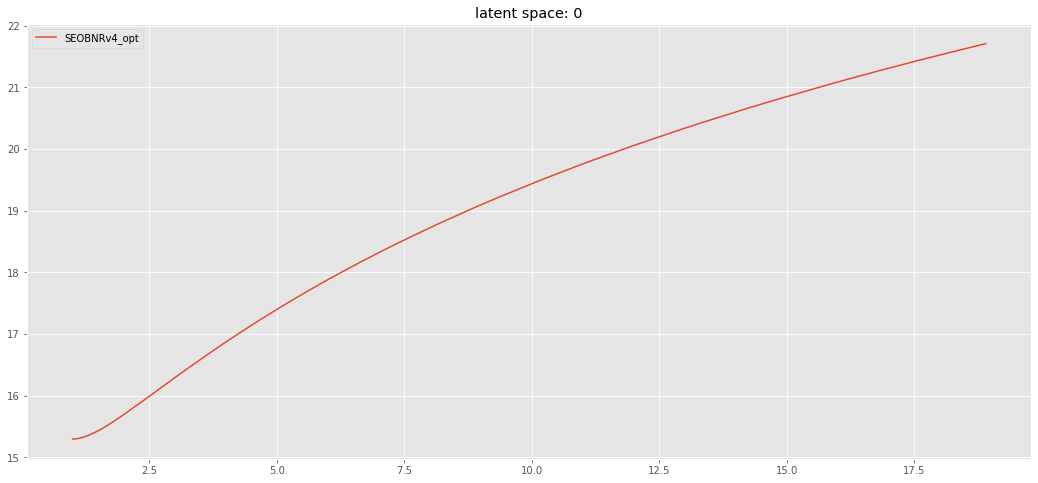

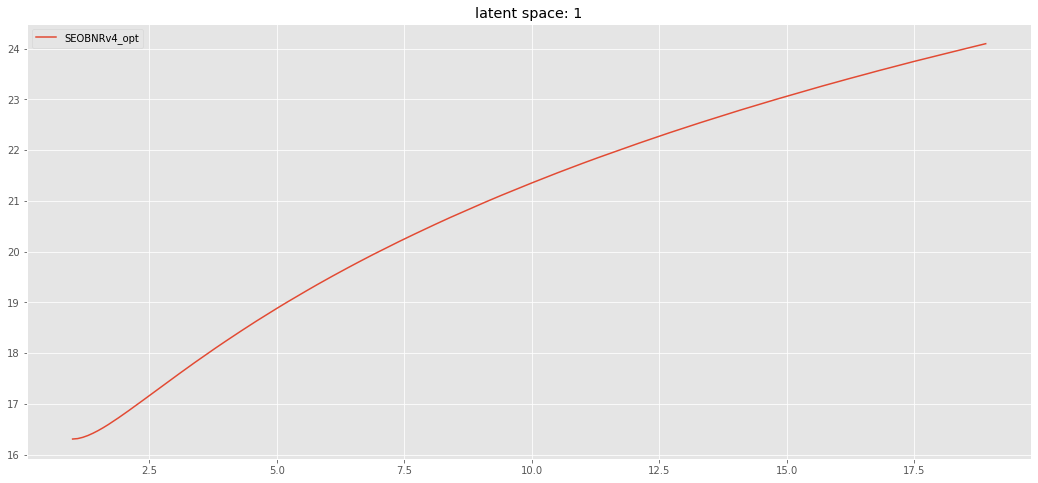

In [128]:
plot_latent_space_1d_for_each_model(model_ts[data_to_model], encoder[data_to_model], figsize=(18, 8))

In [129]:
interpolations_min_max[data_to_model] = interpolate_latent_space_min_max(model_ts[data_to_model], encoder[data_to_model])

In [130]:
interpolations[data_to_model] = interpolate_latent_space(model_ts[data_to_model], encoder[data_to_model])

In [131]:
# plt.figure()
# plt.plot(model_ts[data_to_model]['IMRPhenomD']['x'], interpolations[data_to_model]['IMRPhenomD'][0](model_ts[data_to_model]['IMRPhenomD']['x']))

In [156]:
def compare_with_models(q, decoder_amp, decoder_phase, amp_interpolations, phase_interpolations, base_model):
    
    other_model = generate_case(q, approx=base_model, data_to_model='Reh22', scale_by_eta=True, npts=5000)
    
    
    amphat = predict(q, decoder_amp, amp_interpolations[base_model]) * scale_param['amp']
    phasehat = predict(q, decoder_phase, phase_interpolations[base_model]) * scale_param['phase']
    
    hhat = amphat * np.exp(-1.j * phasehat)
    
    wave1 = other_model['y'][0]
    wave2 = np.real(hhat[0])
    
    print(f"mass-ratio: {q}")
    print(f"match: {match(wave1, wave2, common_times)}")
    print(f"comparing with base_model: {base_model}")
    
    plt.figure(figsize=(22, 12))
    plt.subplot(2, 1, 1)
    plt.plot(common_times, wave1)
    plt.plot(common_times, wave2, ls='--')
    
    plt.subplot(2, 1, 2)
    plt.plot(common_times, wave1)
    plt.plot(common_times, wave2, ls='--')
    plt.xlim(-100, 100)

In [157]:
# compare_with_models(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations['amp'], interpolations['phase'], base_model='IMRPhenomD')

mass-ratio: 3.742
match: 0.9998036837842698
comparing with base_model: SEOBNRv4_opt


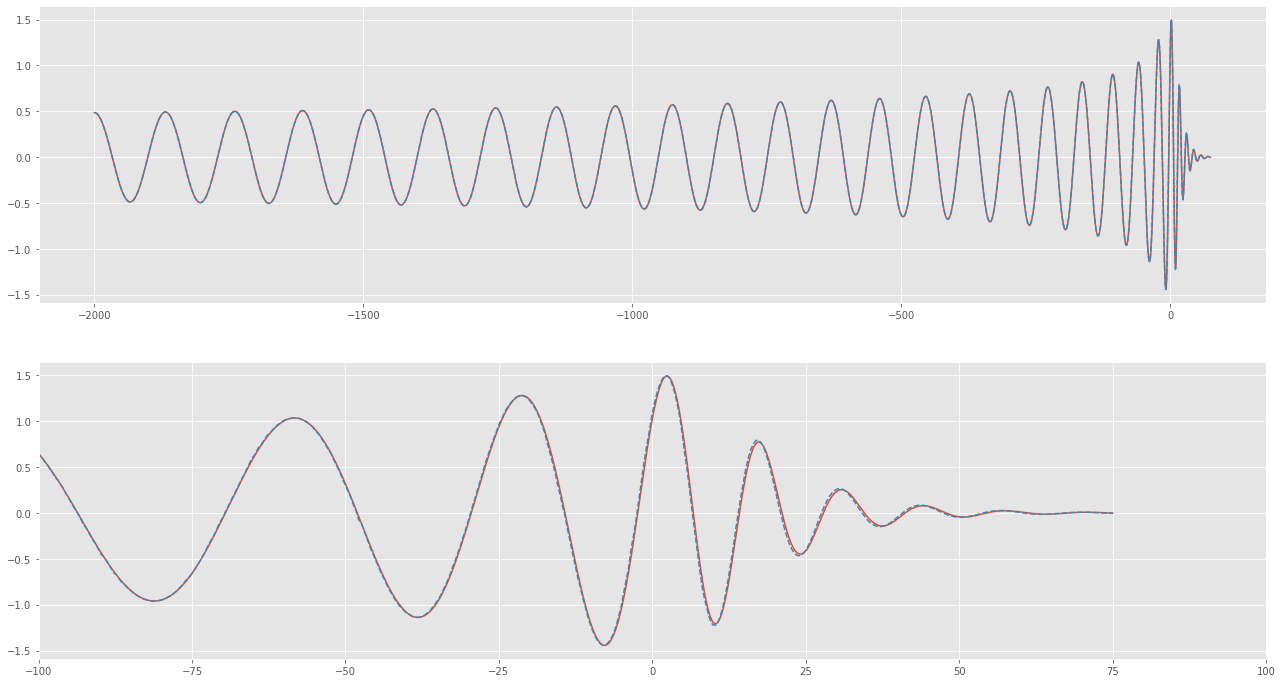

In [175]:
compare_with_models(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations['amp'], interpolations['phase'], base_model='SEOBNRv4_opt')

In [70]:
# compare_with_models(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations['amp'], interpolations['phase'], base_model='IMRPhenomC')

In [200]:
def vary_latent_space(q, decoder_amp, decoder_phase, amp_interpolations_min_max, phase_interpolations_min_max, base_model):
    
    other_model = generate_case(q, approx=base_model, data_to_model='Reh22', scale_by_eta=True, npts=5000)
    
    amp_min_val = np.asarray([f(q) for f in amp_interpolations_min_max['min']])
    amp_max_val = np.asarray([f(q) for f in amp_interpolations_min_max['max']])
    
    phase_min_val = np.asarray([f(q) for f in phase_interpolations_min_max['min']])
    phase_max_val = np.asarray([f(q) for f in phase_interpolations_min_max['max']])
    
    print(amp_min_val)
    print(amp_max_val)
    
    print(phase_min_val)
    print(phase_max_val)
    
    
    amp_latent_num = len(amp_min_val)
    phase_latent_num = len(phase_min_val)
    amp_vals = np.asarray([np.linspace(amp_min_val[i], amp_max_val[i], 10) for i in range(amp_latent_num)]).T
    phase_vals = np.asarray([np.linspace(phase_min_val[i], phase_max_val[i], 10) for i in range(phase_latent_num)]).T
    
    print(amp_vals.shape)
    
    amphat = decoder_amp.predict(amp_vals)
    phasehat = decoder_phase.predict(phase_vals)
    
    
    hhat = amphat * np.exp(-1.j * phasehat)
    
    wave1 = other_model['y'][0]
    wave2s = np.real(hhat)
#     wave2s = np.abs(hhat)
    
    print(f"mass-ratio: {q}")
    print(f"match: {match(wave1, wave2s[0], common_times)}")
    print(f"comparing with base_model: {base_model}")
    
    plt.figure(figsize=(22, 12))
    plt.subplot(2, 1, 1)
    plt.plot(common_times, wave1)
    for wave2 in wave2s:
        plt.plot(common_times, wave2, ls='--')
    
    plt.subplot(2, 1, 2)
    plt.plot(common_times, wave1)
    for wave2 in wave2s:
        plt.plot(common_times, wave2, ls='--')
    plt.xlim(-100, 100)

[ 9.27864088 30.56718041]
[ 9.27864088 30.56718041]
[-949.38824255  335.29559076]
[-949.38824255  335.29559076]
(10, 2)
mass-ratio: 13.158
match: 0.048346441322724636
comparing with base_model: SEOBNRv4_opt


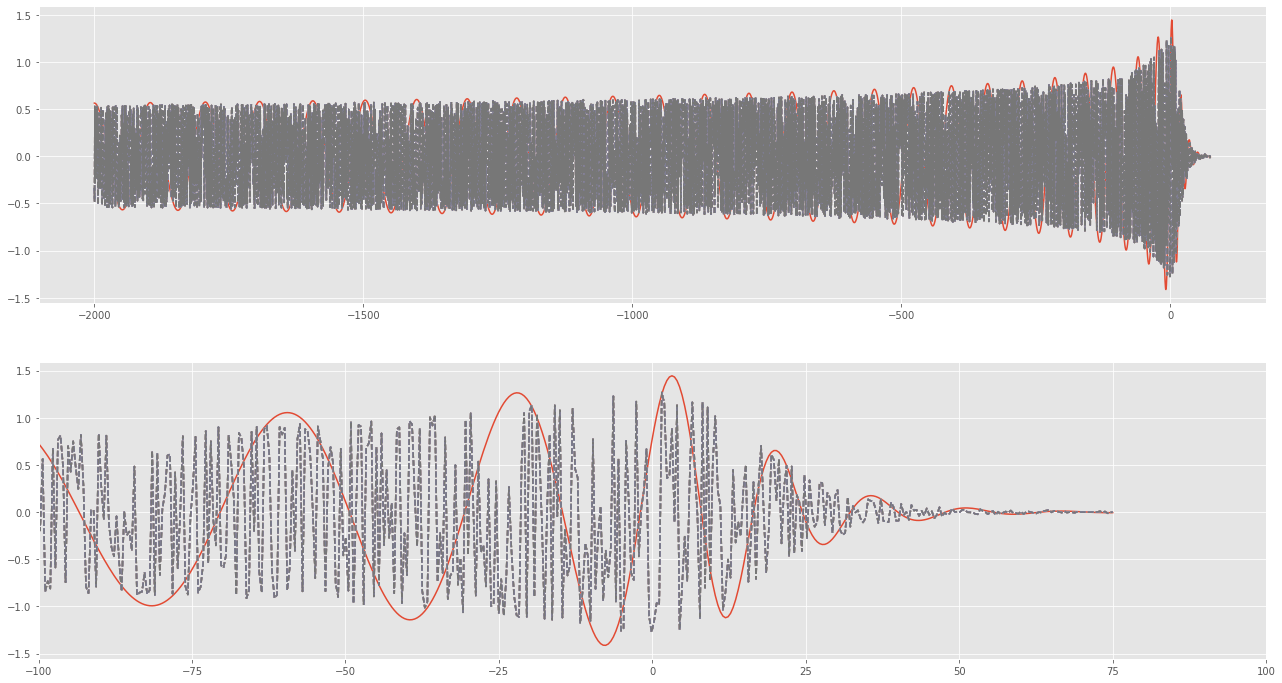

In [201]:
# vary_latent_space(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations_min_max['amp'], interpolations_min_max['phase'], base_model='IMRPhenomC')
vary_latent_space(np.around(np.random.uniform(1, 18), 3), decoder['amp'], decoder['phase'], interpolations_min_max['amp'], interpolations_min_max['phase'], base_model='SEOBNRv4_opt')